In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [14]:
df = pd.read_csv('./data/haberman.data', delimiter = ',')
df.columns = df.columns.str.strip()
df.head()

,age_of_patient,year_of_operation,pos_nodes,outcome
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [32]:
# 1 = the patient survived 5 years or longer
# 2 = the patient died within 5 years
df.outcome.value_counts()

1    225
2     81
Name: outcome, dtype: int64

In [17]:
group = df.groupby('outcome').mean()
group

,age_of_patient,year_of_operation,pos_nodes
outcome,,,
1,52.017778,62.862222,2.791111
2,53.679012,62.827160,7.456790


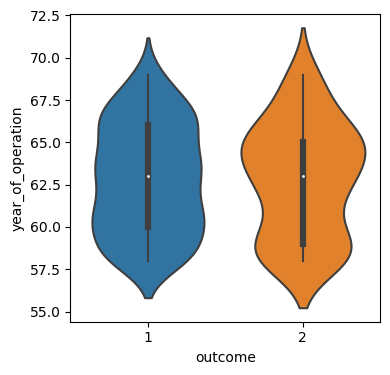

In [19]:
plt.figure(figsize = (4,4))
sns.violinplot(data = df, x = 'outcome', y = 'year_of_operation')
plt.show()

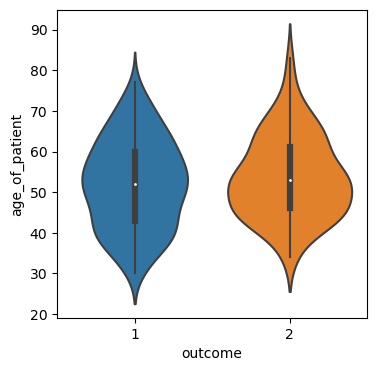

In [21]:
plt.figure(figsize = (4,4))
sns.violinplot(data = df, x = 'outcome', y = 'age_of_patient')
plt.show()

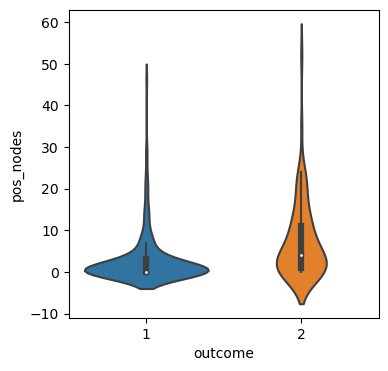

In [24]:
plt.figure(figsize = (4,4))
sns.violinplot(data = df, x = 'outcome', y = 'pos_nodes')
plt.show()

### Perm fun

In [31]:
def perm_fun(df, len_a, col):
    a = df.sample(n = len_a, replace = False)
    b = df[~df.index.isin(a.index)]
    
    return a[col].mean() - b[col].mean()

### Age 

In [37]:
df.outcome.value_counts().loc[2]

81

In [34]:
group.loc[1].age_of_patient

52.01777777777778

In [38]:
len_a = df.outcome.value_counts().loc[2]

actual_diff = group.loc[2].age_of_patient - group.loc[1].age_of_patient
diffs = [perm_fun(df, len_a, 'age_of_patient') for _ in range(1000)]

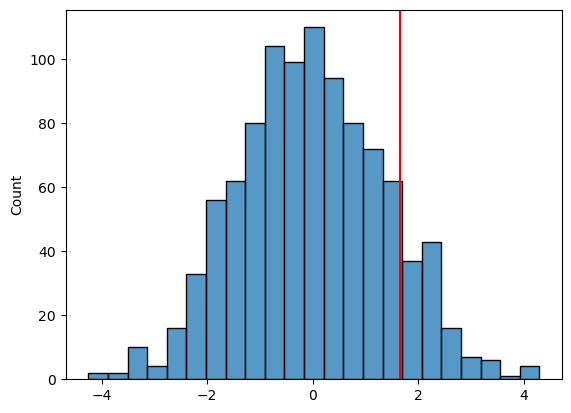

In [39]:
plt.figure()
sns.histplot(diffs)
plt.axvline(x = actual_diff, color = 'red')
plt.show()

In [41]:
p_val = np.array([np.abs(diff) > actual_diff for diff in diffs])
p_val.mean()

0.242

### Positive Axillary Nodes Detected

In [42]:
len_a = df.outcome.value_counts().loc[2]

actual_diff = group.loc[2].pos_nodes - group.loc[1].pos_nodes
diffs = [perm_fun(df, len_a, 'pos_nodes') for _ in range(1000)]

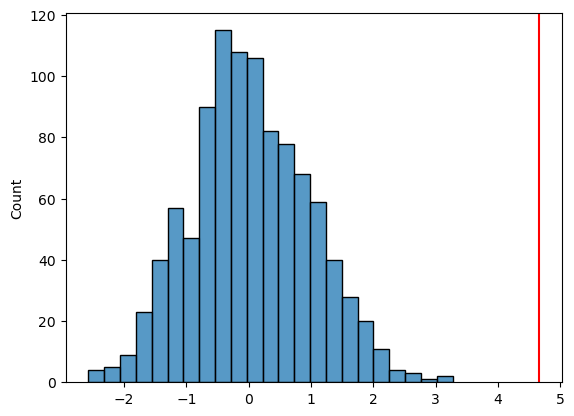

In [43]:
plt.figure()
sns.histplot(diffs)
plt.axvline(x = actual_diff, color = 'red')
plt.show()

In [44]:
p_val = np.array([np.abs(diff) > actual_diff for diff in diffs])
p_val.mean()

0.0

### Modeling

In [54]:
# only good indicator for model appears to be positive number of auxillary nodes detected

predictors = 'pos_nodes'
outcome = 'outcome'

X = df[predictors]
y = df[outcome]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

### Grid Search CV for best hyperparameters

In [80]:
params = [{
    "n_estimators": [100,200,300],
    "max_depth": [3,5,7,9],
    "min_samples_split": [5,10,20],
    "criterion": ['gini', 'entropy']
}]

In [84]:
rf = RandomForestClassifier()
rf_gridsearch = GridSearchCV(rf, param_grid = params)

rf_gridsearch.fit(np.array(X_train).reshape(-1,1), y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [3, 5, 7, 9],
                          'min_samples_split': [5, 10, 20],
                          'n_estimators': [100, 200, 300]}])

In [85]:
rf_gridsearch.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_split': 10,
 'n_estimators': 100}

In [87]:
rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 5, min_samples_split = 10)
rf.fit(np.array(X_train).reshape(-1,1), y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=10)

In [89]:
df_test = df[df.index.isin(X_test.index)].copy()
df_test['RFPrediction'] = rf.predict(np.array(df_test[predictors]).reshape(-1,1))
df_test.head()

,age_of_patient,year_of_operation,pos_nodes,outcome,RFPrediction
3,31,59,2,1,1
4,31,65,4,1,1
7,34,59,0,2,1
8,34,66,9,2,2
11,34,61,10,1,2


In [90]:
print("Accuracy score:", np.round(accuracy_score(df_test.outcome, df_test.RFPrediction), 3))
print("Precsion score:", np.round(precision_score(df_test.outcome, df_test.RFPrediction), 3))
print("Recall score:", np.round(recall_score(df_test.outcome, df_test.RFPrediction), 3))

Accuracy score: 0.696
Precsion score: 0.806
Recall score: 0.783
